In [1]:
import sys
import os

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root)
print(os.getcwd())

/Users/kashyap/Library/CloudStorage/ProtonDrive-kashyap.suthar07@pm.me-folder/Capstone_Project/models


In [2]:
from utils.preprocessing import load_and_trasnform, preprocessing_data
from utils.save_metrics import save_metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
# Load raw X, y
X, y = load_and_trasnform("../data/train.csv")

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (1119, 80)
X_val shape: (280, 80)


In [4]:
preprocessor = preprocessing_data(X_train)

In [5]:
mlp = MLPRegressor(
    early_stopping=True,
    max_iter=3000,
)

In [6]:
mlp_pipe = Pipeline([("preprocessor", preprocessor), ("mlp", mlp)])

In [7]:
param_dist_mlp = {
    "mlp__hidden_layer_sizes": [(256,128), (256,128,64),(512,256,128),(128,64)],
    "mlp__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
    "mlp__activation": ['relu'],
    "mlp__solver": ["adam"],
    "mlp__batch_size": ["auto"],
}

In [8]:
mlp_search = RandomizedSearchCV(
    mlp_pipe,
    param_distributions=param_dist_mlp,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2,
    n_iter=15
)

In [9]:
mlp_search.fit(X_train, y_train)
print("Best MLP params:", mlp_search.best_params_)
best_model = mlp_search.best_estimator_

y_val_prd = best_model.predict(X_val)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best MLP params: {'mlp__solver': 'adam', 'mlp__hidden_layer_sizes': (512, 256, 128), 'mlp__batch_size': 'auto', 'mlp__alpha': 0.001, 'mlp__activation': 'relu'}


In [10]:
mse = mean_squared_error(y_val, y_val_prd)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_prd)
r2 = r2_score(y_val, y_val_prd)

print("Neural Network")
print(" MSE:", mse)
print(" RMSE:", rmse)
print(" MAE:", mae)
print(" R2:", r2)


Neural Network
 MSE: 366843916.97332454
 RMSE: 19153.16989360572
 MAE: 13684.515805204683
 R2: 0.8846699224994059


In [11]:
save_metrics("Neural Network", mse, rmse, mae, r2)

Saved metrics to /Users/kashyap/Library/CloudStorage/ProtonDrive-kashyap.suthar07@pm.me-folder/Capstone_Project/utils/../metrics/neural_network.json


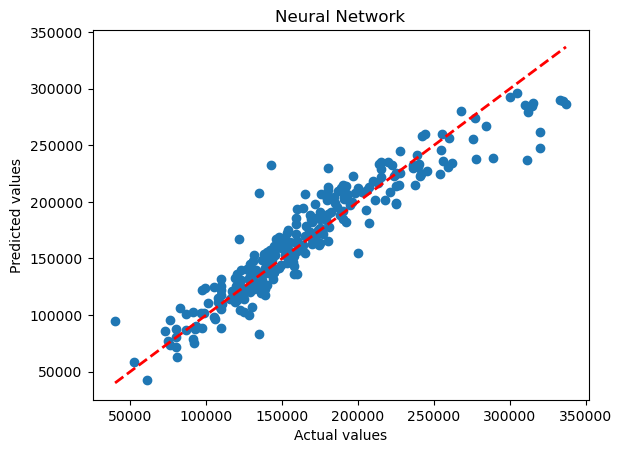

In [12]:
plt.figure()
plt.scatter(y_val, y_val_prd)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Neural Network")
plt.show()